In [1]:
import math
from __future__ import division
from collections import OrderedDict
from striped.job import SinglePointStripedSession as Session, IPythonDisplay
import histbook as hb

job_server = ("ifdb01.fnal.gov", 8765)
session = Session(job_server)

In [2]:
bg_datasets = """
Summer16.DYJetsToLL_M-50_TuneCUETP8M1_13TeV-madgraphMLM-pythia8
""".split()
bg_datasets = [ds.strip() for ds in bg_datasets if ds.strip()]

In [3]:
import fnal_column_analysis_tools.lookup_tools as lookup_tools
import cloudpickle
import zlib

# import a bunch of correction histograms
weightsext = lookup_tools.extractor()
correctionDescriptions = open("newCorrectionFiles.txt").readlines()
weightsext.add_weight_sets(correctionDescriptions)
weightsext.finalize()
weights_eval = weightsext.make_evaluator()
#let's pickle and zip it
weights_names = zlib.compress(cloudpickle.dumps(weightsext._extractor__names))
weights_vals = zlib.compress(cloudpickle.dumps(weightsext._extractor__weights))

#dir(weights_eval)
#print(weights_eval["muScaleFactor_TightId_Iso"])

In [4]:
all_hists = OrderedDict()
cat = hb.groupby("category", keeporder=True)

def add_1d(*args,**kwargs):
    h = None 
    if 'wgt' in kwargs:
        h = hb.Hist(hb.bin(*args), cat, weight=kwargs['wgt'])
    else:
        h = hb.Hist(hb.bin(*args), cat)    
    all_hists[args[0]] = h
    return h


add_1d("stripeThroughput", 300, 0, 1000000)
add_1d("stripeTime", 1000, 0.0, 0.5)
add_1d("leadingLeptonPt", 100, 0, 500,wgt="weight")
add_1d("zMass", 120, 60, 180,wgt="weight")

display_opts = {'width': 300, 'height': 300}
def buildDisplay(hists, cols=2):
    rows = []
    for iRow in range(int(math.ceil(len(hists)/cols))):
        hrowname = hists.keys()[iRow*cols:(iRow+1)*cols]
        hrow = hists.values()[iRow*cols:(iRow+1)*cols]
        rows.append(hb.beside(*tuple(h.overlay("category").step(n, **display_opts) for h,n in zip(hrow, hrowname))))
    return IPythonDisplay(
        hb.below(*tuple(rows))
    )

display = buildDisplay(all_hists)



class Callback:
    def __init__(self, display):
        self.Display = display
        
    def on_histogram_update(self, nevents):
        self.Display.update()


In [5]:
#__worker_class__

# break sandbox
# https://stackoverflow.com/questions/33880646/access-module-sys-without-using-import-machinery
sys = next(getattr(c, f).__func__.__globals__['sys'] for c in ().__class__.__base__.__subclasses__() for f in dir(c) if isinstance(getattr(c, f, None), type((lambda: 0).__get__(0))) and 'sys' in getattr(c, f).__func__.__globals__)
if 'sandbox' in sys.modules:
    __builtins__['__import__'] = sys.modules['sandbox'].saved_import
    #import subprocess
    #raise Exception(subprocess.check_output("pip list".split(" ")))
    
import numpy as np
import awkward
import uproot_methods
import cloudpickle
import zlib
import time
from collections import OrderedDict
import fnal_column_analysis_tools
from fnal_column_analysis_tools.analysis_objects import JaggedCandidateArray
from fnal_column_analysis_tools.striped import ColumnGroup, PhysicalColumnGroup, jaggedFromColumnGroup
from fnal_column_analysis_tools.striped.WorkerAddons import Timer
from fnal_column_analysis_tools.lookup_tools import evaluator

class Worker(Timer):
    def __init__(self):
        super(Worker,self).__init__()
        self.Columns = ["Electron.charge", "Electron.p4", "Electron.tightID",
                        "Muon.charge", "Muon.p4", "Muon.tightID",
                        "Trigger.pass"]
        self.weights_eval = None        
        
    def run(self, events, job):
        stripelen = len(events.Muon.count)
        self.set_tic('all')
    
        if self.weights_eval is None:            
            self.weights_eval = evaluator(cloudpickle.loads(zlib.decompress(job["weights_names"])),
                                          cloudpickle.loads(zlib.decompress(job["weights_vals"])))
        weights_eval = self.weights_eval
        
        #35: HLT_Ele32_WPTight_Gsf_v
        #36: HLT_Ele35_WPTight_Gsf_v
        #45: HLT_IsoMu20_v
        #46: HLT_IsoMu22_v
        #48: HLT_IsoMu24_v
        #50: HLT_IsoMu27_v
        # yes, this is trivial for now but perhaps it's more fun later
        triggerColumns = ColumnGroup(events,"Trigger","pass")
        triggers = jaggedFromColumnGroup(triggerColumns)
        
        #only care about processing events which have triggered
        events_triggered = ( (triggers["pass"][:,35] > 0) |
                             (triggers["pass"][:,36] > 0) |
                             (triggers["pass"][:,45] > 0) |   
                             (triggers["pass"][:,46] > 0) |
                             (triggers["pass"][:,48] > 0) |
                             (triggers["pass"][:,50] > 0)   )
        
        electronCols = PhysicalColumnGroup(events,"Electron","p4","charge","tightID")
        electrons_new = jaggedFromColumnGroup(electronCols)                
        
        muonCols = PhysicalColumnGroup(events,"Muon","p4","charge","tightID")
        muons_new = jaggedFromColumnGroup(muonCols)                

        electrons_new['SF'] = weights_eval["eleScaleFactor_TightId_POG"](electrons_new.eta,
                                                                         electrons_new.pt)
        muons_new['SF'] = weights_eval["muScaleFactor_TightId_Iso"](np.absolute(muons_new.eta),
                                                                    muons_new.pt)

        electrons_trig = electrons_new#[events_triggered] 
        muons_trig = muons_new#[events_triggered]

        electron_selection = ( (electrons_trig.pt > 20) &
                               (np.abs(electrons_trig.eta) < 2.5) &
                               (electrons_trig.tightID > 0) )
        muon_selection = ( (muons_trig.pt > 20) &
                           (np.abs(muons_trig.eta) < 2.4) &
                           (muons_trig.tightID > 0) )

        selected_electrons = electrons_trig[electron_selection]        
        selected_muons = muons_trig[muon_selection]

        dielectrons = selected_electrons.distincts()
        dimuons = selected_muons.distincts()

        selected_dielectrons = dielectrons[((dielectrons.at(0).pt > 38) | (dielectrons.at(1).pt > 38))] 
        selected_dimuons = dimuons[((dimuons.at(0).pt > 30) | (dimuons.at(1).pt > 30))]

        zee_cat = ((selected_dielectrons.counts == 1) & 
                   (selected_dimuons.counts == 0))
        #fill electrons
        final_ees = selected_dielectrons[zee_cat]
        SF1e = final_ees.at(0).SF
        SF2e = final_ees.at(1).SF
        job.fill(
            category="ee",
            leadingLeptonPt=np.maximum(final_ees.at(0).pt,
                                       final_ees.at(1).pt).flatten(),
            zMass=final_ees.mass.flatten(),
            weight=(SF1e*SF2e).flatten()
        )            
            
        zmm_cat = ((selected_dimuons.counts == 1) & 
                   (selected_dielectrons.counts == 0))
        final_mms = selected_dimuons[zmm_cat]
        SF1mu = final_mms.at(0).SF
        SF2mu = final_mms.at(1).SF
        #fill muons
        job.fill(
            category="mm",
            leadingLeptonPt=np.maximum(final_mms.at(0).pt,
                                       final_mms.at(1).pt).flatten(),
            zMass=final_mms.mass.flatten(),
            weight=(SF1mu*SF2mu).flatten()
        ) 
                
        #fill both
        #job.fill(
        #    category="all",
        #    leadingLeptonPt=np.hstack([np.maximum(selected_dimuons[zmm_cat].at(0).p4.pt,
        #                                          selected_dimuons[zmm_cat].at(1).p4.pt).flatten(), 
        #                               np.maximum(selected_dielectrons[zee_cat].at(0).p4.pt,
        #                                          selected_dielectrons[zee_cat].at(1).p4.pt).flatten()]),
        #)
        #job.fill(
        #    category="all",            
        #    zMass=np.hstack([selected_dielectrons[zee_cat].p4.mass.flatten(), 
        #                     selected_dimuons[zmm_cat].p4.mass.flatten()])
        #)
        
        #profiling info
        self.set_toc('all')
        self.fill_job_timer_info(stripelen,job)        
        

Summer16.DYJetsToLL_M-50_TuneCUETP8M1_13TeV-madgraphMLM-pythia8         49.144 M events,   4.328 M events/sec


Total events processed: 49144274 in 19.3 seconds -> 2.549672 million events/second


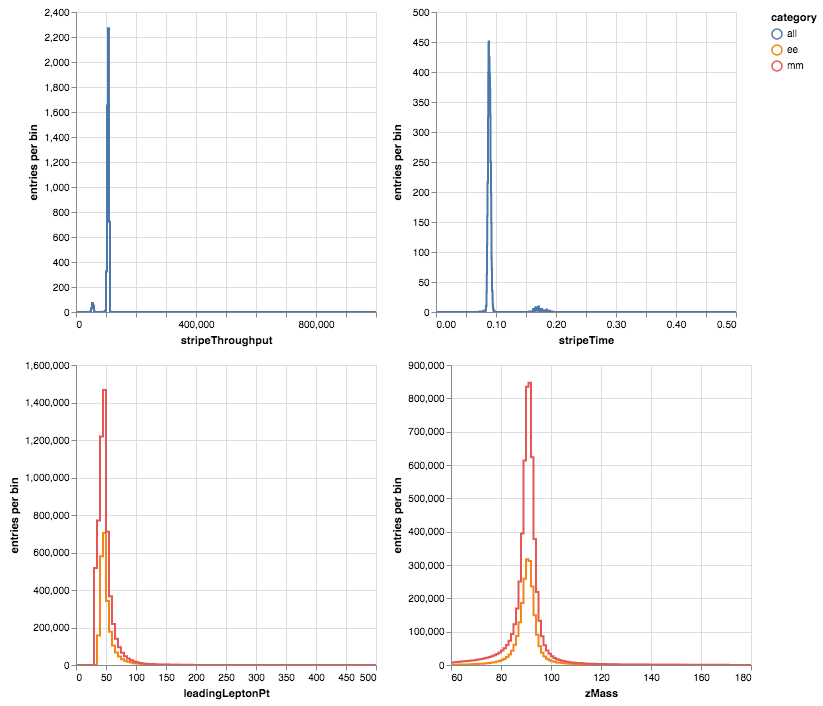

In [6]:
display.init()
callback = Callback(display)
_ = map(lambda h: h.clear(), all_hists.values())

import time
nevents_total = 0
t1 = time.time()
for dataset in bg_datasets:
    job = session.createJob(dataset, 
            fraction=1.,
            user_callback=callback, 
            user_params = {"weights_names":weights_names,
                           "weights_vals":weights_vals},
            histograms=all_hists.values()
    )
    job.run()
    runtime = job.TFinish - job.TStart
    nevents = job.EventsProcessed
    nevents_total += nevents
    print "%-70s %7.3f M events, %7.3f M events/sec" % (dataset[:70], float(nevents)/1e6, nevents/runtime/1000000)
    #print "%s: %.6f million events/second" % (dataset, nevents/runtime/1000000)
    display.update()

t2 = time.time()
print "Total events processed: %d in %.1f seconds -> %.6f million events/second" %(nevents_total, t2-t1, nevents_total/(t2-t1)/1000000)


In [7]:
def moment(df, n, binval='mid'):
    """
        df: DataFrame with single-level MultiIndex specifying binning, and a shape of (nbins, )
        n: n-th moment of distribution, ignoring (over/under/nan)flow bins
        binval in ['left', 'right', 'mid']: point in the bin to use as bin value
    """
    vals = np.array([getattr(b, binval) for b in df.index if type(b) is not str])[1:-1]
    weights = np.array(df)[1:-2]  # ignore nanflow (last bin)
    moment = sum(pow(vals, n)*weights) / sum(weights)
    return moment

def mean(df, binval='mid'):
    return moment(df, 1, binval)

def std(df, binval='mid'):
    return np.sqrt(max(moment(df, 2, binval) - moment(df, 1, binval)**2, 0.))

In [8]:
stripeThroughput = mean(all_hists['stripeThroughput'].pandas()['count()']["all"])
nWorkers = 180
processingTime = nevents_total/stripeThroughput/nWorkers
print "Stripe processing throughput: %.0f evt/s" % stripeThroughput
print "Total throughput: %.0f evt/s" % (nevents_total/(t2-t1), )
print "Striped server overhead: %.1f %%" % ((1-processingTime/(t2-t1))*100, )

Stripe processing throughput: 105576 evt/s
Total throughput: 2549672 evt/s
Striped server overhead: 86.6 %
